In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
#%env HDF5_USE_FILE_LOCKING=FALSE
    
import sys
sys.path.insert(1, '../../models/PFN')
from dataset_pfn import PFNDataset
from pfn_model import ParticleFlowNetwork as Model
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import seaborn as sns

In [50]:
#Training/Testing path
preprocessed=True
dataset=''
train_path = "../../datasets/train.h5"
val_path = "../../datasets/val.h5"
test_path = "../../datasets/test.h5"

In [51]:
test_set = PFNDataset(test_path, preprocessed)
test_data, test_mask, test_label = test_set[:]

In [52]:
model = Model(input_dims = 3)
model.load_state_dict(torch.load("../../models/PFN/models/PFN_best"))
model = model.cuda()
model.eval()

FcLayers = []
PhiLayers = []
for layer in model._modules['fc']:
    print(layer)
    FcLayers.append(layer)
print('\n')
for layer in model._modules['phi']:
    print(layer)
    PhiLayers.append(layer)

Sequential(
  (0): Linear(in_features=256, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
)
Linear(in_features=100, out_features=2, bias=True)
Softmax(dim=1)


Sequential(
  (0): Linear(in_features=3, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
)


In [53]:
def PHINeuronFiringEvaluator(layers, label=0):
    myDL = DataLoader(test_set, batch_size=1024)
    NeuronFiringMatrix = []
    layer_tags = []
    with torch.no_grad():
        for idx, (d,m,l) in enumerate(myDL):
            keep_indices = l[:,label] == 1
            d = d[keep_indices, :, :]
            m = m[keep_indices, :, :]
            d = torch.flatten(d, start_dim=0, end_dim=1).cuda()
            for ii, layer in enumerate(layers):
                d = layer.forward(d)
                if idx == 0:
                    NeuronFiringMatrix.append(d.cpu().numpy().sum(0))
                    layer_tags.append("PHI-{}".format(ii))
                else:
                    NeuronFiringMatrix[ii] += d.cpu().numpy().sum(0)
    return NeuronFiringMatrix, layer_tags


def FCNeuronFiringEvaluator(layers, data):
    d = data.cuda()
    NeuronFiringMatrix = []
    layer_tags = []
    with torch.no_grad():
        for ii, layer in enumerate(layers):
            d = layer.forward(d)
            NeuronFiringMatrix.append(d.cpu().numpy().sum(0))
            layer_tags.append("FC-{}".format(ii))
            
    return NeuronFiringMatrix, layer_tags
        

def evalFC(model, data, mask_indices = [-1], mask_values = [0.]):
    lfs = data.cuda()
    for mask_index, mask_value in zip(mask_indices, mask_values):
        if mask_index >= 0:
            lfs[:, mask_index] = mask_value*torch.ones(lfs[:, mask_index].shape)  
    for ii, layer in enumerate(FcLayers):
        if ii == len(FcLayers)-1: 
            res = layer.forward(lfs).cpu()
        elif ii == len(FcLayers)-2:
            lfs = layer.forward(lfs)
            psmax = lfs.cpu()
        else:
            lfs = layer.forward(lfs)
    return psmax, res

def evalPHI(model, test_set):
    myDL = DataLoader(test_set, batch_size=1024)
    with torch.no_grad():
        for idx, (d, m, l) in enumerate(myDL):
            d2 = torch.flatten(d, start_dim=0, end_dim=1)
            lfs = model._modules['phi'].forward(d2.cuda())
            lfs = torch.stack(torch.split(lfs.permute(1, 0), 200, dim=1), 0)
            if m is not None:
                lfs = lfs * m.cuda().bool().float()
            
            lfs = lfs.sum(-1)
            this_lfs = lfs.cpu()  
            psmax, res = evalFC(model, lfs)
            # res = model._modules['fc'].forward(lfs)
            if idx == 0:
                latents = this_lfs.cpu()
                labels = l.cpu()
                presoftmax = psmax.cpu()
                preds = res.cpu()
            else:
                latents = torch.cat((latents, this_lfs.cpu()), 0)
                labels = torch.cat((labels, l.cpu()), 0)
                presoftmax  = torch.cat((presoftmax, psmax.cpu()), 0)
                preds  = torch.cat((preds, res.cpu()), 0)
            if idx == 100:
                break
    return latents, labels, presoftmax, preds

In [54]:
baseline_latents, baseline_labels, baseline_presoftmax, baseline_preds = evalPHI(model, test_set)
auc_baseline = roc_auc_score(baseline_labels[:, 0].numpy(), baseline_preds[:, 0].numpy())*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 99.7387%


In [55]:
FM0_phi, tags_phi = PHINeuronFiringEvaluator(PhiLayers, label=0)
FM1_phi, tags_phi = PHINeuronFiringEvaluator(PhiLayers, label=1)

In [56]:
def ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline', save=False):
    tag = 'baseline' if tag == ''else tag.strip('_')
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    print(N_cols, N_rows)
    Nnodes = 0
    for ii in range(len(FiringMatrix_0)):
        max_0 = FiringMatrix_0[ii].max()
        max_1 = FiringMatrix_1[ii].max()
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
        FiringMatrix_1[ii] = FiringMatrix_1[ii]/max_1
        Nnodes += len(FiringMatrix_0[ii])
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], 
                                           np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
            FiringMatrix_1[ii] = np.append(FiringMatrix_1[ii], 
                                           np.ones(N_rows - len(FiringMatrix_1[ii]))*np.nan)
    
    FiringMatrix_0 = np.array(FiringMatrix_0)
    FiringMatrix_1 = np.array(FiringMatrix_1)
    s0 = np.sum(FiringMatrix_0 < 0.2)/Nnodes
    s1 = np.sum(FiringMatrix_1 < 0.2)/Nnodes
    sall = np.sum(np.maximum(FiringMatrix_0, FiringMatrix_1) < 0.2)/Nnodes
    print("Sparsity measure (RNA < 0.2) for background jets: ", s0)
    print("Sparsity measure (RNA < 0.2) for signal jets: ", s1)
    print("Overall sparsity measure (RNA < 0.2): ", sall)
    ## The relative node firing rates for class 0 are multiplied by a factor of -1
    ## to represent the NAPs of two classes side by side for a visual comparison
    weights = np.append(-1*FiringMatrix_0.reshape(-1), FiringMatrix_1.reshape(-1)) 
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.25
    x = np.append(x, np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.75)
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    y = np.append(y,y)
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(0,N_cols+0.25,0.5), np.arange(N_rows+1)],
                   weights = weights, cmap = 'bwr', cmin = -1, cmax = 1)
    axes.set_facecolor('grey')

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=40) 
    axes.set_xlabel('Network Activation Layers', fontsize = 40)
    axes.set_ylabel('Node in hidden layer', fontsize = 40)
    axes.set_xticks(np.arange(N_cols) + 0.5) 
    axes.set_xticklabels(layer_tags, rotation='vertical',  fontsize=40)
    axes.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()
    if save:
        plt.savefig("figures/NAP_PFN_{}.png".format(tag))
    plt.show()
    
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    weights = np.abs(FiringMatrix_1.reshape(-1) - FiringMatrix_0.reshape(-1))
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.5
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(N_cols+1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'Reds')

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=40) 
    axes.set_facecolor('grey')
    axes.set_xlabel('Network Activation Layers', fontsize=40)
    axes.set_ylabel('Node in hidden layer', fontsize=40)
    axes.set_xticks(np.arange(N_cols) + 0.5)
    axes.set_xticklabels(layer_tags, rotation='vertical', fontsize=40)
    axes.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()
    if save:
        plt.savefig("figures/dNAP_PFN_{}.png".format(tag))
    plt.show()
    return (s0, s1, sall)

3 256
Sparsity measure (RNA < 0.2) for background jets:  0.8706140350877193
Sparsity measure (RNA < 0.2) for signal jets:  0.868421052631579
Overall sparsity measure (RNA < 0.2):  0.868421052631579


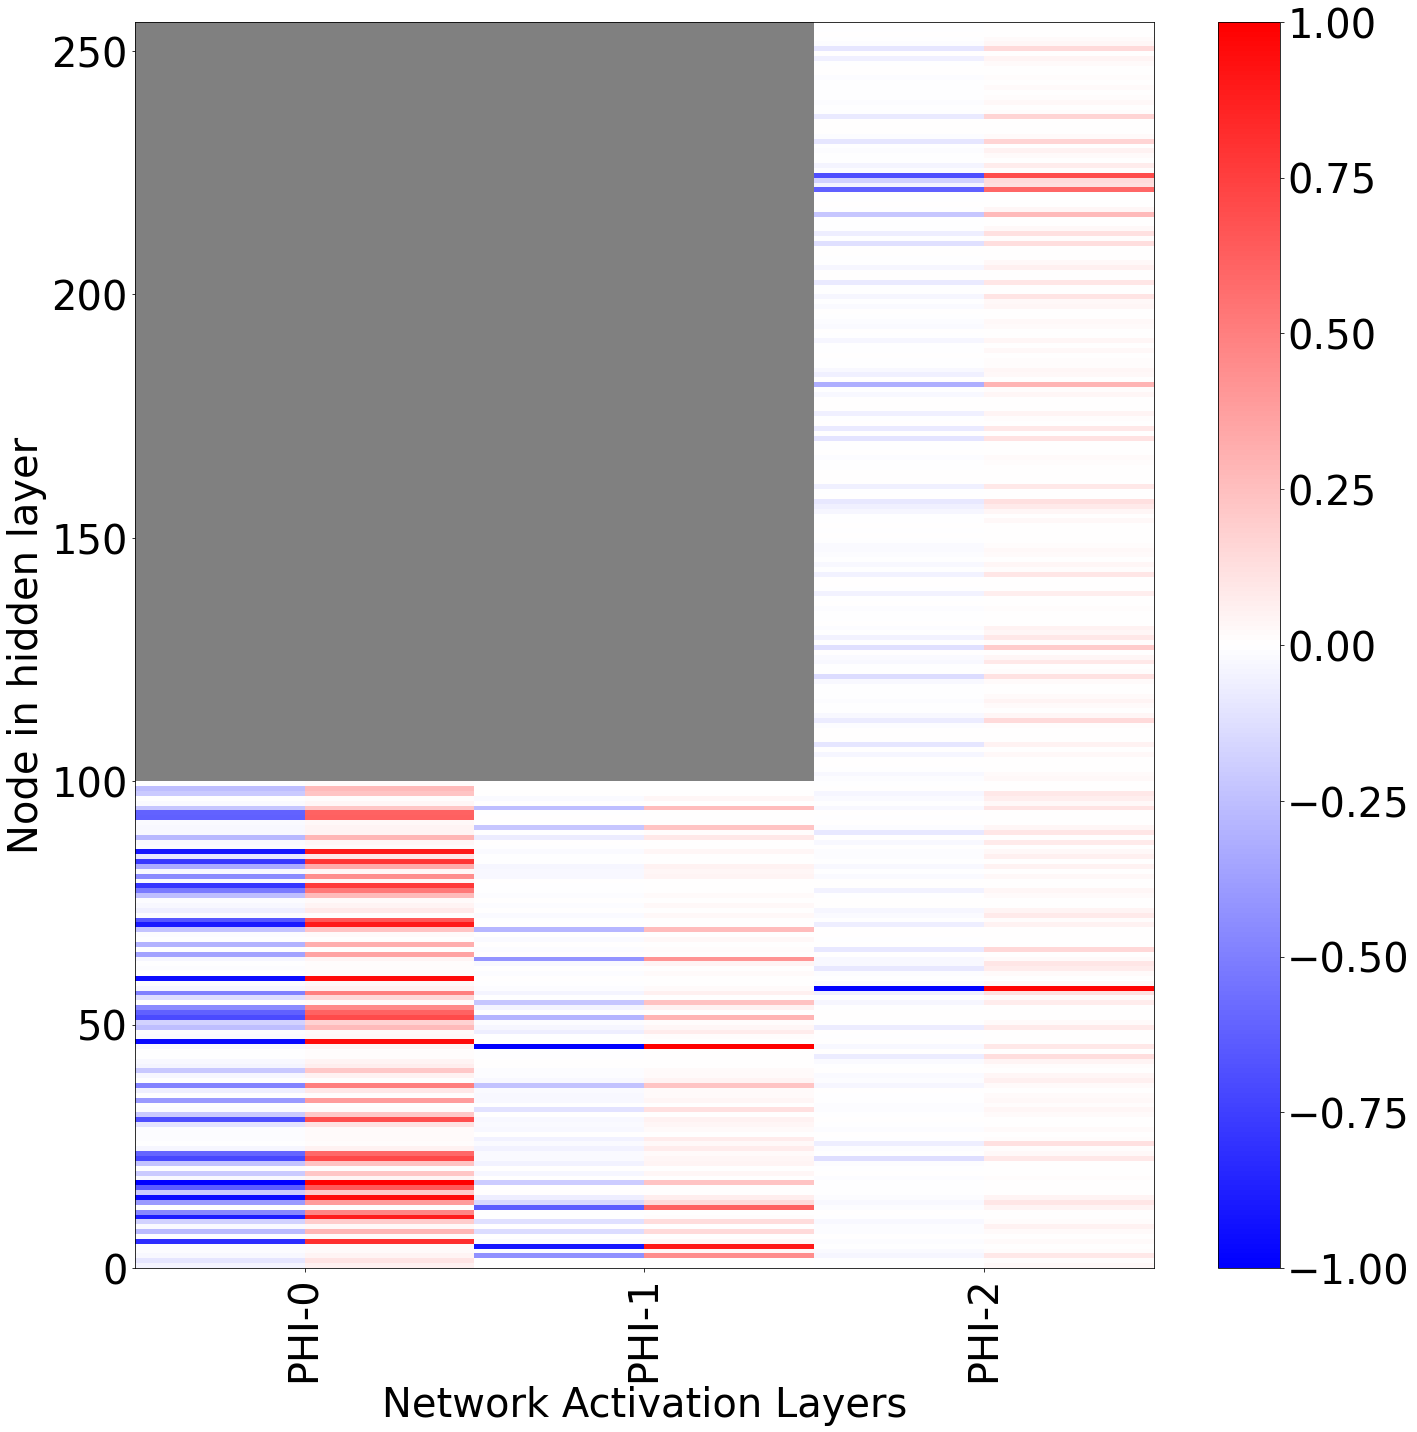

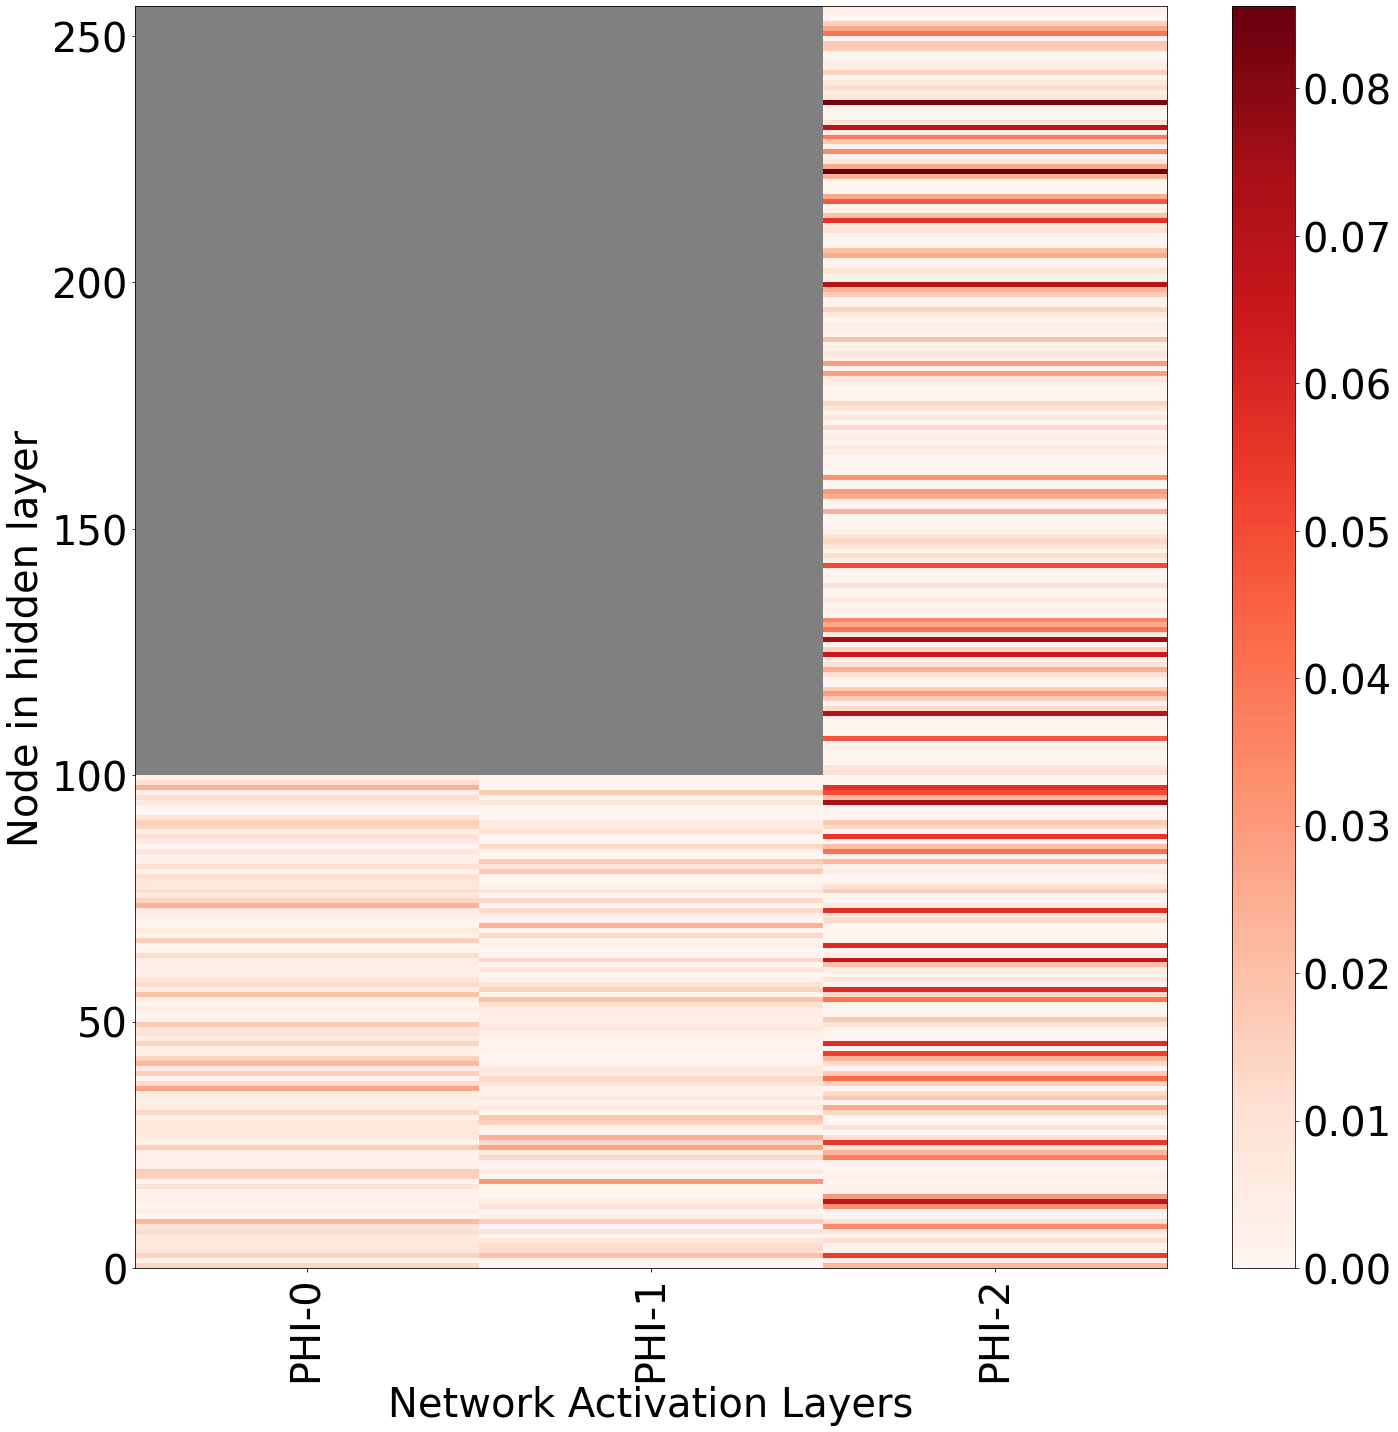

(0.8706140350877193, 0.868421052631579, 0.868421052631579)

In [57]:
ActivationMapPlotter(FM0_phi, FM1_phi, tags_phi, tag='baseline', save=True)

In [58]:
sig_indices = baseline_labels[:,0] == 0
bkg_indices = baseline_labels[:,0] == 1

FM0_fc, tags_fc = FCNeuronFiringEvaluator(FcLayers[:3], baseline_latents[bkg_indices, :])
FM1_fc, tags_fc = FCNeuronFiringEvaluator(FcLayers[:3], baseline_latents[sig_indices, :])

3 100
Sparsity measure (RNA < 0.2) for background jets:  0.7166666666666667
Sparsity measure (RNA < 0.2) for signal jets:  0.71
Overall sparsity measure (RNA < 0.2):  0.4666666666666667


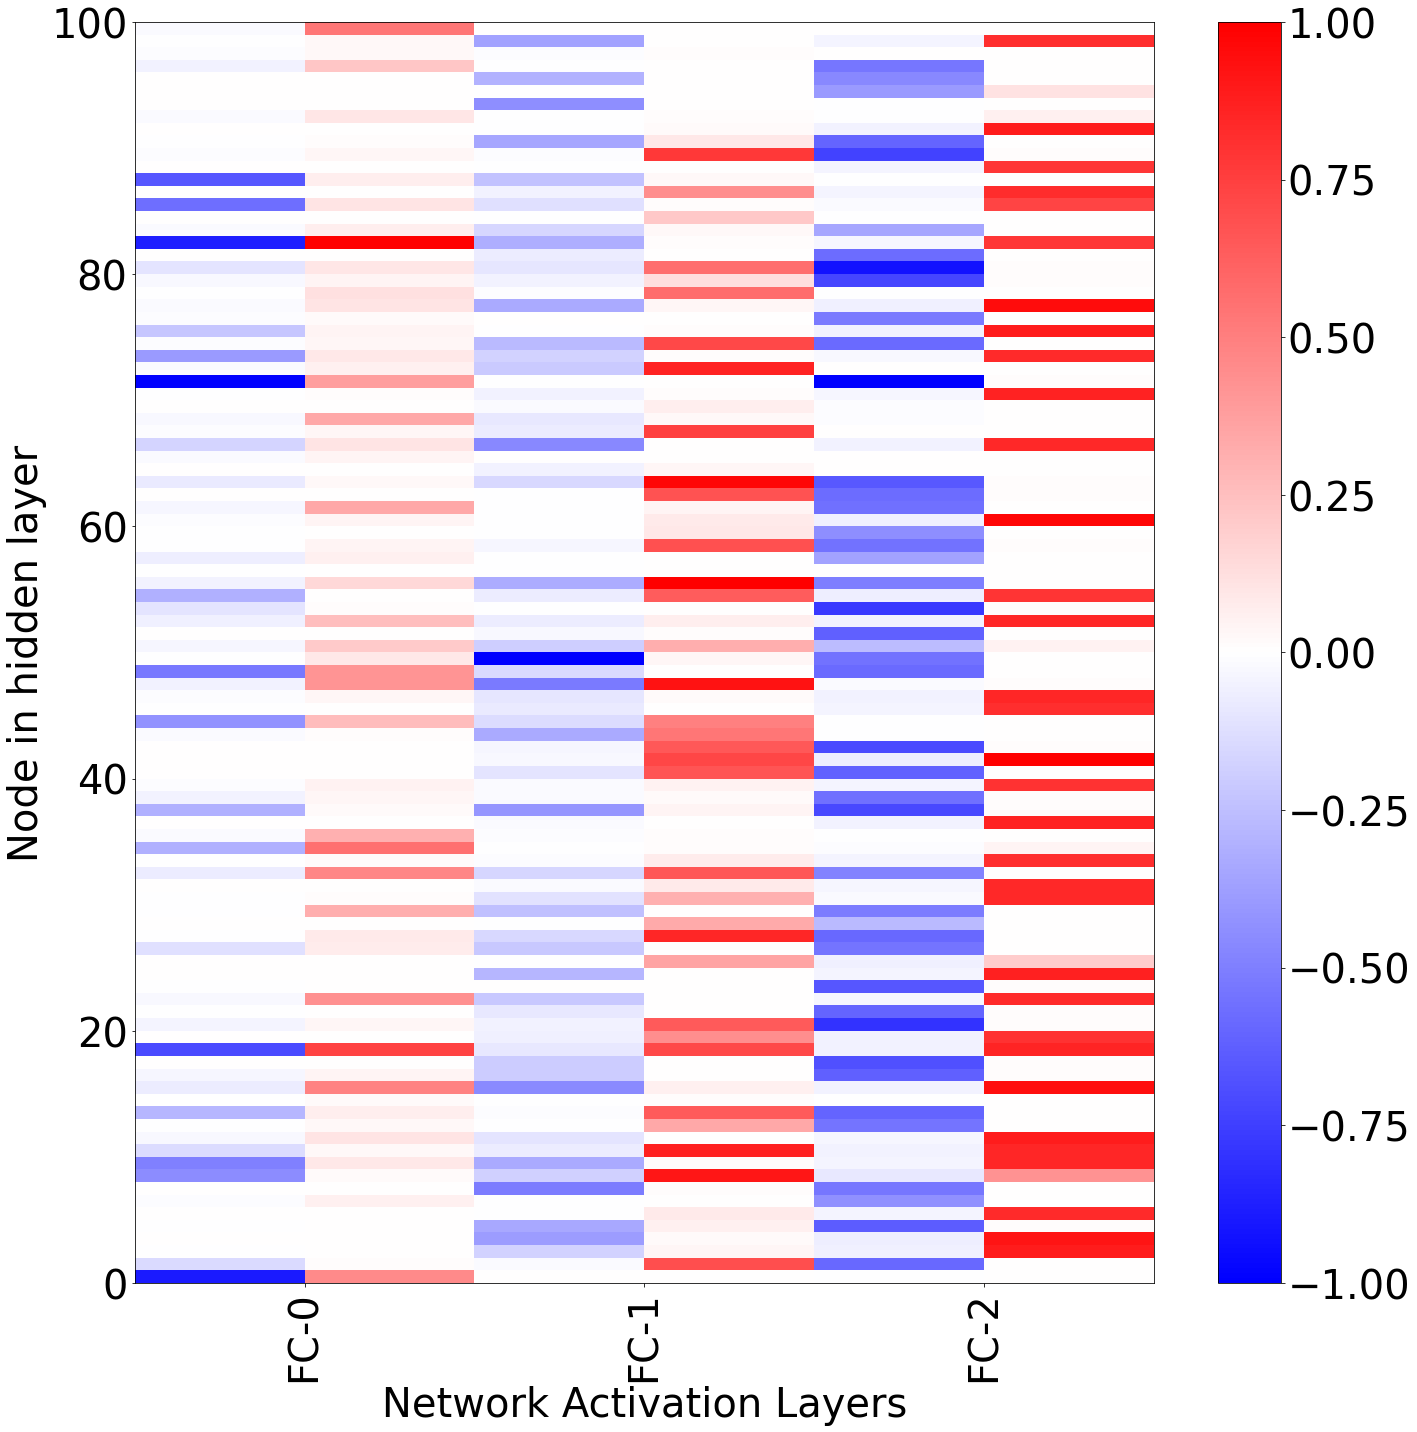

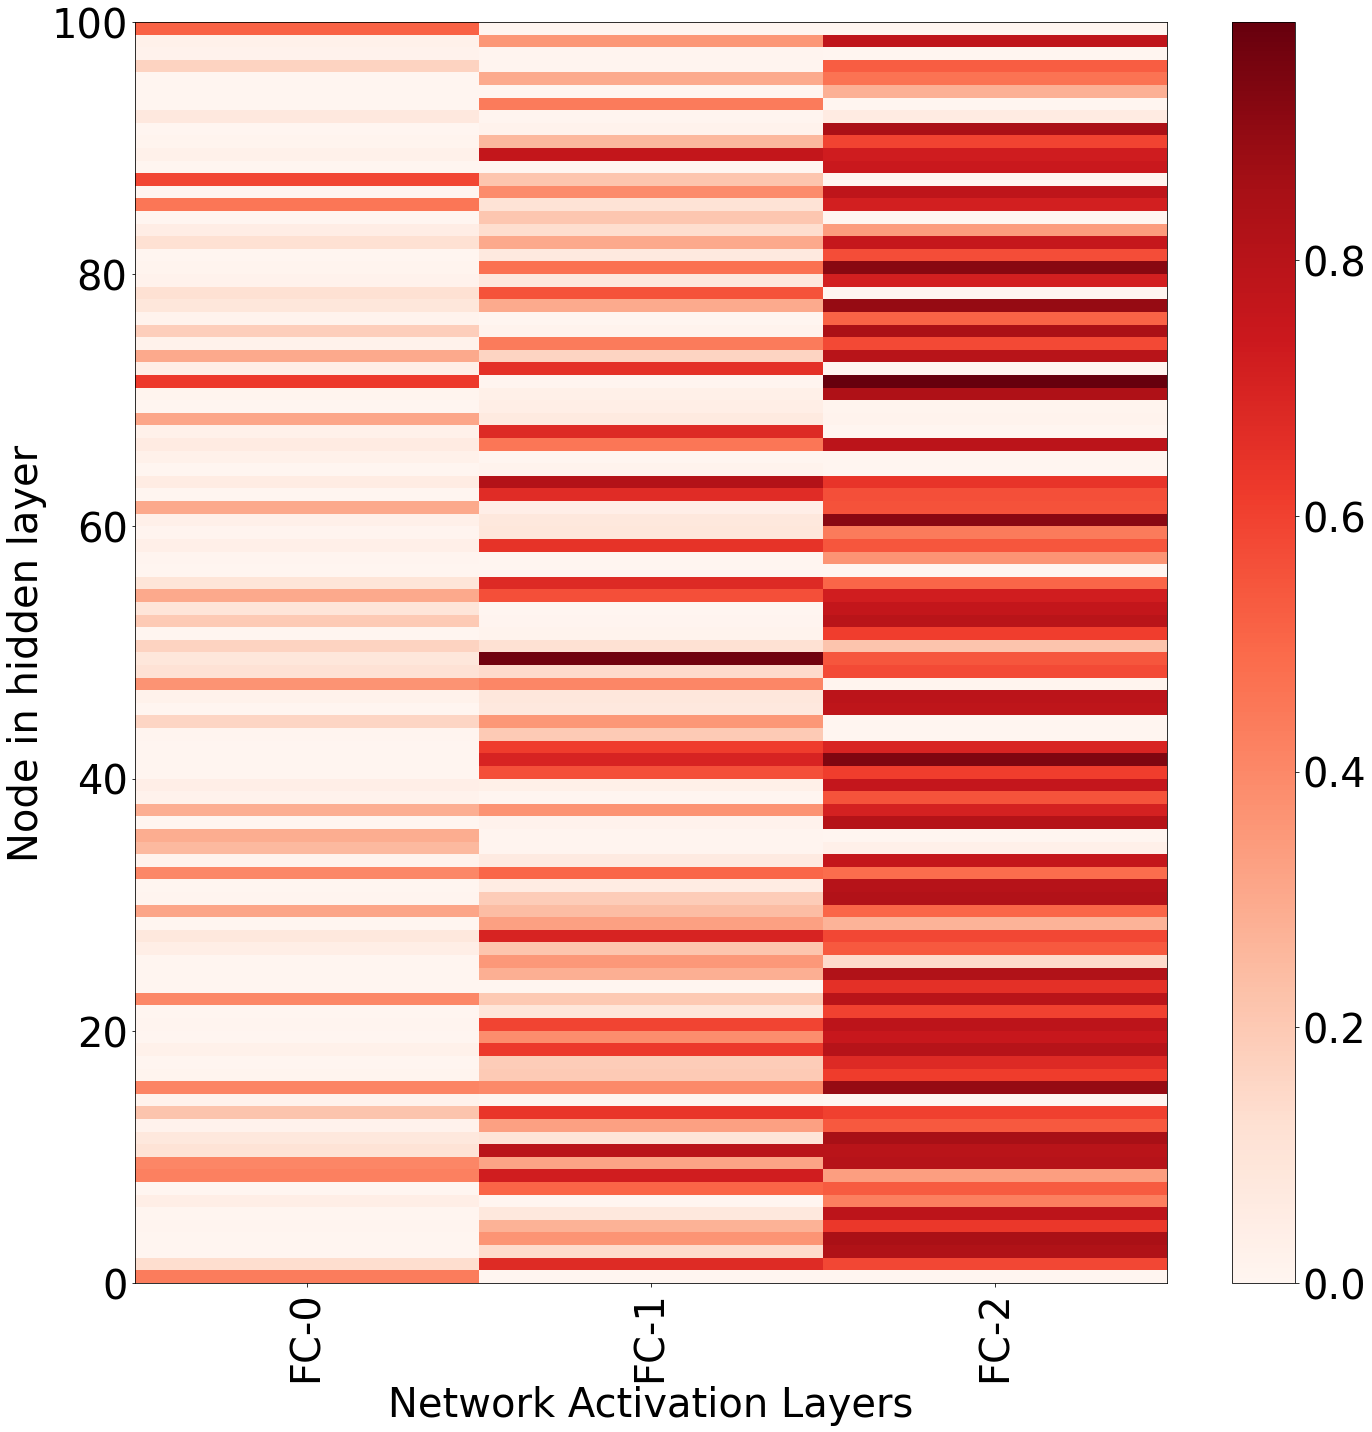

(0.7166666666666667, 0.71, 0.4666666666666667)

In [59]:
ActivationMapPlotter(FM0_fc, FM1_fc, tags_fc, tag='baseline', save=True)